# Statistics for WLASL

In [90]:
import json
from configs import WLASL_ROOT, SPLIT_DIR, CLASSES_PATH
from pathlib import Path
from typing import List, Dict, TypedDict, TypeAlias, Literal, Optional
import matplotlib.pyplot as plt



### Splits

In [73]:
split_dir = Path(WLASL_ROOT) / SPLIT_DIR
splits = [p for p in split_dir.iterdir() if p.suffix == '.json']
print(f'Found splits: {[p.name for p in splits]}')

Found splits: ['asl1000.json', 'all.json', 'asl100.json', 'asl300.json', 'asl2000.json']


In [74]:
wlasl100 = json.load(open(split_dir / 'asl100.json'))
wlasl300 = json.load(open(split_dir / 'asl300.json'))
wlasl1000 = json.load(open(split_dir / 'asl1000.json'))
wlasl2000 = json.load(open(split_dir / 'asl2000.json'))

classes = json.load(open(CLASSES_PATH))

### Output

In [75]:
out_dir = Path('./info')
if out_dir.exists():
    print(list(out_dir.iterdir()))

[PosixPath('info/wlasl_class_list.txt'), PosixPath('info/wlasl_class_list.json'), PosixPath('info/wlasl_100_stats.json')]


## From the WLASL GitHUB page

Data Description
-----------------

* `gloss`: *str*, data file is structured/categorised based on sign gloss, or namely, labels.

* `bbox`: *[int]*, bounding box detected using YOLOv3 of (xmin, ymin, xmax, ymax) convention. Following OpenCV convention, (0, 0) is the up-left corner.

* `fps`: *int*, frame rate (=25) used to decode the video as in the paper.

* `frame_start`: *int*, the starting frame of the gloss in the video (decoding
with FPS=25), *indexed from 1*.

* `frame_end`: *int*, the ending frame of the gloss in the video (decoding with FPS=25). -1 indicates the gloss ends at the last frame of the video.

* `instance_id`: *int*, id of the instance in the same class/gloss.

* `signer_id`: *int*, id of the signer.

* `source`: *str*, a string identifier for the source site.

* `split`: *str*, indicates sample belongs to which subset.

* `url`: *str*, used for video downloading.

* `variation_id`: *int*, id for dialect (indexed from 0).

* `video_id`: *str*, a unique video identifier.


## Statistical Methods


Naming convention (note this might be better the other way round): 
- set: one of train, test and val
- split one of asl100, asl300, asl1000, asl2000


In [76]:
AVAIL_SETS: TypeAlias = Literal['train', 'val', 'test']
AVAIL_SPLITS: TypeAlias = Literal['asl100', 'asl300', 'asl1000', 'asl2000']

class instance_dict(TypedDict):
    """Represents a single instance of a gloss in the dataset."""
    bbox: List[int]
    frame_end: int
    frame_start: int
    instance_id: int
    signer_id: int
    source: str
    split: str
    url: str
    variation_id: int
    video_id: str

class gloss_dict(TypedDict):
    """Represents a single gloss and its associated instances."""
    gloss: str
    instances: List[instance_dict]

class class_stats(TypedDict):
    """Represents statistics for a single gloss class."""
    num_instances: int
    num_signers: int
    num_variations: int

class set_stats(TypedDict):
    """Represents statistics for a data subset (train/val/test)."""
    num_instances: int
    num_signers: int
    per_class_stats: Dict[str, class_stats] #key is the class name
    

class split_stats(TypedDict):
    """Represents statistics for a single dataset split (asl100, asl300, asl1000, asl2000)."""
    num_classes: int
    num_instances: int
    num_signers: int
    per_set_stats: Dict[AVAIL_SETS, set_stats]

    

In [77]:
def get_class_stats(instances: List[instance_dict]) -> class_stats:
    """Collects statistics for a single class based on its instances."""
    num_instances = 0
    num_signers = 0
    num_variations = 0

    signer_ids = set()
    variation_ids = set()
    for instance in instances:
        num_instances += 1
        signer_ids.add(instance["signer_id"])
        variation_ids.add(instance["variation_id"])

    num_signers = len(signer_ids)
    num_variations = len(variation_ids)
    return {
        "num_instances": num_instances,
        "num_signers": num_signers,
        "num_variations": num_variations,
    }


def get_set(instances: List[instance_dict], set_name: AVAIL_SETS) -> List[instance_dict]:
    """Filters instances to only include those belonging to a specific set (train/val/test)."""
    filtered_instances = []
    for instance in instances:
        if instance["split"] == set_name:
            filtered_instances.append(instance)
    return filtered_instances

def seperate_by_set(glosses: List[gloss_dict]) -> Dict[AVAIL_SETS, List[gloss_dict]]:
    """Separates glosses by their set (train/val/test)."""
    sets = {
        "train": [],
        "val": [],
        "test": []
    }
    for gloss in glosses:
        instances = gloss["instances"]
        for set_name in sets.keys():
            filtered_instances = get_set(instances, set_name)
            
            sets[set_name].append({
                "gloss": gloss["gloss"],
                "instances": filtered_instances
            })
    return sets


def get_per_class_stats(glosses: List[gloss_dict]) -> Dict[str, class_stats]:
    """Collects statistics for all classes in a list of gloss_dicts (recommend seperating into test/val/train first)"""
    per_class_stats = {}
    for gloss in glosses:
        class_name = gloss["gloss"]
        instances = gloss["instances"]
        per_class_stats[class_name] = get_class_stats(instances)
    return per_class_stats


def get_unique_signers(dataset: List[gloss_dict]) -> set[int]:
    """Get set of unique sighners in a list of gloss_dicts"""
    signers = set()
    for gloss_d in dataset:
        for instance_dict in gloss_d["instances"]:
            signers.add(instance_dict["signer_id"])
    return signers

def get_num_instances(dataset: List[gloss_dict]) -> int:
    """Get the number of instances in a dataset"""
    
    num_instances = 0
    for gloss_d in dataset:
        num_instances += len(gloss_d["instances"])
    return num_instances


def get_set_stats(subset: List[gloss_dict]) -> set_stats:
    """Get stats for a particular set (one of test/val.train, seperate first)"""
    return set_stats(
        num_instances=get_num_instances(subset),
        num_signers=len(get_unique_signers(subset)),
        per_class_stats=get_per_class_stats(subset),
    )



def get_per_set_stats(glosses: List[gloss_dict]) -> Dict[AVAIL_SETS, set_stats]:
    """Seperates into sets, then returns stats per set"""
    sets = seperate_by_set(glosses)
    per_set_stats = {}
    for set_name, glosses_subset in sets.items():
        per_set_stats[set_name] = get_set_stats(glosses_subset)
    return per_set_stats


def get_split_stats(split: List[gloss_dict]) -> split_stats:
    return split_stats(
        num_classes=len(split),
        num_instances=get_num_instances(split),
        num_signers=len(get_unique_signers(split)),
        per_set_stats=get_per_set_stats(split)
    )


## Output methods

In [ ]:
#Generated by copilot from here:
# =============================================================================
#                       LaTeX TABLE GENERATION
# =============================================================================

def latex_set_summary_table(split_name: AVAIL_SPLITS, stats: split_stats) -> str:
    """
    Generate a LaTeX table summarising statistics for each set (train/val/test)
    for a given split.

    Parameters
    ----------
    split_name : AVAIL_SPLITS
        Name of the dataset split, e.g. "asl100".
    stats : split_stats
        Statistics structure for the split.

    Returns
    -------
    str
        A LaTeX table environment as a string.
    """
    rows = []
    for set_name, s in stats["per_set_stats"].items():
        rows.append(
            f"{set_name} & {s['num_instances']} & {s['num_signers']} & "
            f"{len(s['per_class_stats'])} \\\\"
        )

    table = r"""
        \begin{table}[h]
        \centering
        \begin{tabular}{lccc}
        \hline
        Set & Instances & Signers & Classes \\
        \hline
        """ + "\n".join(rows) + r"""
        \hline
        \end{tabular}
        \caption{Statistics summary for split %s.}
        \end{table}
        """ % split_name

    return table.strip()


def latex_class_stats_table(
    split_name: AVAIL_SPLITS,
    set_name: AVAIL_SETS,
    set_stats_obj: set_stats,
) -> str:
    """
    Generate a LaTeX table listing per-class statistics for a chosen subset.

    Parameters
    ----------
    split_name : AVAIL_SPLITS
        Name of the dataset split (e.g., "asl100").
    set_name : AVAIL_SETS
        The subset to summarise (train/val/test).
    set_stats_obj : set_stats
        The statistics object for the chosen set.

    Returns
    -------
    str
        A LaTeX table environment as a string.
    """
    rows = []
    for gloss, cstats in set_stats_obj["per_class_stats"].items():
        rows.append(
            f"{gloss} & {cstats['num_instances']} & "
            f"{cstats['num_signers']} & {cstats['num_variations']} \\\\"
        )

    table = r"""
        \begin{table}[h]
        \centering
        \begin{tabular}{lccc}
        \hline
        Gloss & Instances & Signers & Variations \\
        \hline
        """ + "\n".join(rows) + r"""
        \hline
        \end{tabular}
        \caption{Class-level statistics for %s (%s split).}
        \end{table}
        """ % (set_name, split_name)

    return table.strip()


# =============================================================================
#                       VISUALISATION HELPERS
# =============================================================================

def barplot_metric(
    per_class: Dict[str, class_stats],
    metric: str,
    top_n: Optional[int] = None,
    title: Optional[str] = None,
    figsize: tuple = (12, 6),
) -> None:
    """
    Create a bar plot for a chosen metric across glosses.

    Parameters
    ----------
    per_class : dict
        Mapping gloss → class_stats.
    metric : str
        One of {"num_instances", "num_signers", "num_variations"}.
    top_n : int, optional
        If provided, only plot the top-N glosses for the chosen metric.
    title : str, optional
        Plot title.
    figsize : tuple
        Matplotlib figure size.
    """
    if metric not in {"num_instances", "num_signers", "num_variations"}:
        raise ValueError(f"Invalid metric: {metric}")

    # Extract metric values per gloss
    items = [(g, stats[metric]) for g, stats in per_class.items()]
    items.sort(key=lambda x: x[1], reverse=True)

    if top_n:
        items = items[:top_n]

    glosses, values = zip(*items)

    plt.figure(figsize=figsize)
    plt.bar(glosses, values)
    plt.xticks(rotation=90)
    plt.ylabel(metric.replace("_", " ").title())
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()


def histogram_metric(
    per_class: Dict[str, class_stats],
    metric: str,
    bins: int = 20,
    title: Optional[str] = None,
    figsize: tuple = (8, 5),
) -> None:
    """
    Plot a histogram of a chosen metric across glosses.

    Parameters
    ----------
    per_class : dict
        Mapping gloss → class_stats.
    metric : str
        One of {"num_instances", "num_signers", "num_variations"}.
    bins : int
        Number of histogram bins.
    title : str, optional
        Plot title.
    figsize : tuple
        Matplotlib figure size.
    """
    if metric not in {"num_instances", "num_signers", "num_variations"}:
        raise ValueError(f"Invalid metric: {metric}")

    values = [stats[metric] for stats in per_class.values()]

    plt.figure(figsize=figsize)
    plt.hist(values, bins=bins)
    plt.xlabel(metric.replace("_", " ").title())
    plt.ylabel("Frequency")
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()


def scatter_instances_vs_signers(
    per_class: Dict[str, class_stats],
    figsize: tuple = (6, 5),
    title: Optional[str] = None,
) -> None:
    """
    Scatter plot of num_instances vs num_signers for each gloss.

    Parameters
    ----------
    per_class : dict
        Mapping gloss → class_stats.
    figsize : tuple
        Figure size.
    title : str, optional
        Plot title.
    """
    x = [c["num_instances"] for c in per_class.values()]
    y = [c["num_signers"] for c in per_class.values()]

    plt.figure(figsize=figsize)
    plt.scatter(x, y, alpha=0.7)
    plt.xlabel("Number of Instances")
    plt.ylabel("Number of Signers")
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()

## Splits

### WLASL-100


In [78]:
out_file = out_dir / 'wlasl_100_stats.json'

In [ ]:
wlasl100_stats = get_split_stats(wlasl100)
json.dump(wlasl100_stats, open(out_file, 'w'), indent=4)

In [94]:
print(latex_set_summary_table("train", wlasl100_stats))

\begin{table}[h]
        \centering
        \begin{tabular}{lccc}
        \hline
        Set & Instances & Signers & Classes \\
        \hline
        train & 1442 & 91 & 100 \\
val & 338 & 69 & 100 \\
test & 258 & 56 & 100 \\
        \hline
        \end{tabular}
        \caption{Statistics summary for split train.}
        \end{table}


In [95]:
print(latex_class_stats_table(split_name="asl100", set_name="train", set_stats_obj=wlasl100_stats["per_set_stats"]["train"]))

\begin{table}[h]
        \centering
        \begin{tabular}{lccc}
        \hline
        Gloss & Instances & Signers & Variations \\
        \hline
        book & 30 & 14 & 1 \\
drink & 25 & 15 & 1 \\
computer & 20 & 12 & 3 \\
before & 18 & 13 & 2 \\
chair & 19 & 11 & 1 \\
go & 19 & 13 & 2 \\
clothes & 18 & 10 & 1 \\
who & 18 & 15 & 1 \\
candy & 17 & 13 & 2 \\
cousin & 16 & 10 & 1 \\
deaf & 16 & 12 & 1 \\
fine & 15 & 11 & 2 \\
help & 15 & 10 & 1 \\
no & 15 & 13 & 1 \\
thin & 15 & 13 & 2 \\
walk & 15 & 13 & 1 \\
year & 15 & 12 & 1 \\
yes & 15 & 12 & 1 \\
all & 14 & 12 & 2 \\
black & 15 & 13 & 1 \\
cool & 14 & 8 & 3 \\
finish & 14 & 10 & 2 \\
hot & 15 & 12 & 1 \\
like & 14 & 10 & 2 \\
many & 15 & 11 & 1 \\
mother & 15 & 10 & 1 \\
now & 15 & 10 & 1 \\
orange & 15 & 13 & 1 \\
table & 15 & 10 & 1 \\
thanksgiving & 15 & 11 & 2 \\
what & 14 & 12 & 2 \\
woman & 15 & 10 & 1 \\
bed & 15 & 12 & 1 \\
blue & 15 & 12 & 1 \\
bowling & 15 & 10 & 1 \\
can & 15 & 10 & 1 \\
dog & 14 & 13 & 2 \\
family & 

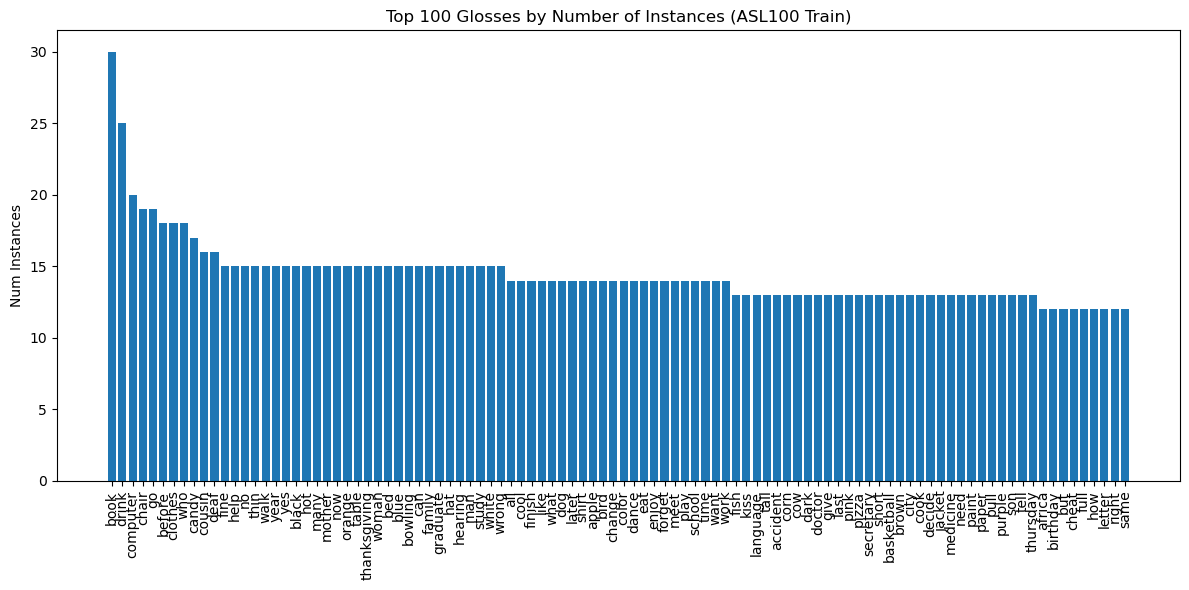

In [99]:
barplot_metric(
    per_class=wlasl100_stats["per_set_stats"]["train"]["per_class_stats"],
    metric="num_instances",
    # metric="num_signers",
    top_n=100,
    title="Top 100 Glosses by Number of Instances (ASL100 Train)"
    # title="Top 100 Glosses by Number of Signers (ASL100 Train)"
)

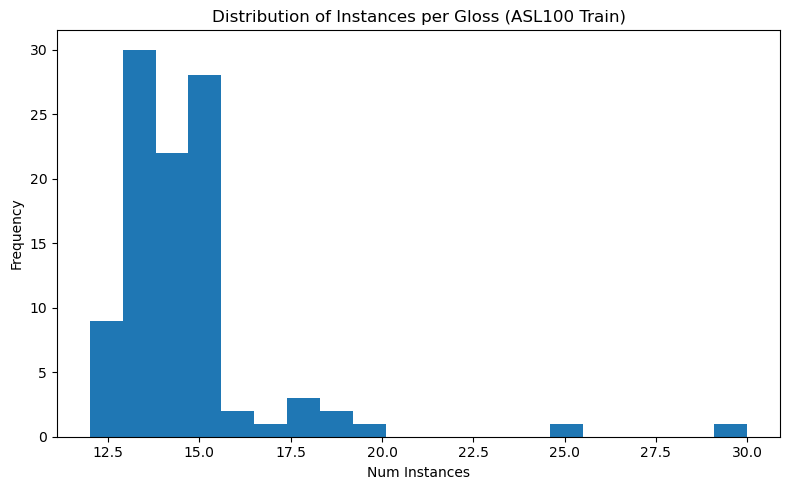

In [100]:
histogram_metric(
    per_class=wlasl100_stats["per_set_stats"]["train"]["per_class_stats"],
    metric="num_instances",
    bins=20,
    title="Distribution of Instances per Gloss (ASL100 Train)"
)

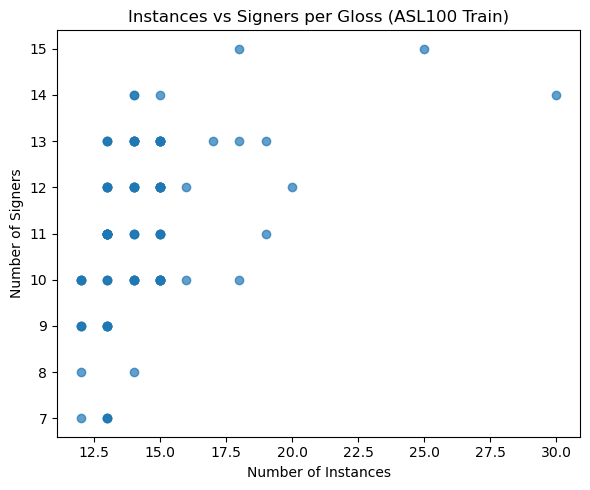

In [101]:
scatter_instances_vs_signers(
    per_class=wlasl100_stats["per_set_stats"]["train"]["per_class_stats"],
    title="Instances vs Signers per Gloss (ASL100 Train)"
)